In [1]:
# Minicons Installation
# Introduction can be found https://kanishka.xyz/post/minicons-running-large-scale-behavioral-analyses-on-transformer-lms/
# Tutorial and code can be found https://github.com/kanishkamisra/minicons/blob/master/examples/surprisals.md
#!pip install minicons

from minicons import scorer
import pandas as pd
import numpy as np
import json
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import torch
from torch.utils.data import DataLoader
from transformers import GPT2LMHeadModel, GPT2TokenizerFast

/tmp/ipykernel_1228059/658913012.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was too old on your system - pyarrow 10.0.1 is the current minimum supported version as of this release.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
#model_path_gpt2_10m = "gpt2-small/checkpoint-trainedtokenizer_10M_whitespace"
#model_path_gpt2_100m = "gpt2-small/checkpoint-trainedtokenizer_100M_whitespace"
model_path_gpt2_10m = "gpt2-10M/checkpoint-10M"
model_path_gpt2_100m = "gpt2-100M/checkpoint-100M"
#model_path_gpt3_10m = "gpt3-small/checkpoint-trainedtokenizer_10M_whitespace"
#model_path_gpt3_100m = "gpt3-small/checkpoint-trainedtokenizer_100M_whitespace"
model_path_babylm_10m = 'colinglab/ConcreteGPT-124M-128ctx-Strict-Small-mixed_bins'
model_path_babylm_100m = 'phonemetransformers/GPT2-85M-BPE-TXT'

# BabbleGPT has special tokens to be filtered out
tokenizer = GPT2TokenizerFast.from_pretrained(model_path_babylm_100m)

# wrap with minicons scorer
lm_scorer_gpt2_10m = scorer.IncrementalLMScorer(model_path_gpt2_10m, device = "cpu")
lm_scorer_gpt2_100m = scorer.IncrementalLMScorer(model_path_gpt2_100m, device = "cpu")
#lm_scorer_gpt3_10m = scorer.IncrementalLMScorer(model_path_gpt3_10m, device = "cpu")
#lm_scorer_gpt3_100m = scorer.IncrementalLMScorer(model_path_gpt3_100m, device = "cpu")
lm_scorer_babylm_10m = scorer.IncrementalLMScorer(model_path_babylm_10m, device = "cpu")
lm_scorer_babylm_100m = scorer.IncrementalLMScorer(model_path_babylm_100m, device = "cpu")
lm_scorer_gpt2 = scorer.IncrementalLMScorer('gpt2', device = "cpu")

In [3]:
tokenizer.all_special_tokens

['UTT_BOUNDARY', 'UNK', 'PAD']

In [4]:
def calculate_surprisal(model_lm_scorer, sentence):
    '''
    Takes in a sentence, and outputs surprisal values for each word.
    '''
    
    input_sentence = sentence
    # token_score() function of Minicons takes in several parameters
    # if surprisal = True, the output value is surprisal instead of log likelihood
    # if base_two = True, the log likelihood will be in base 2
    # see Minicons documentations for details
    # score tokens
    token_surprisals = model_lm_scorer.token_score(input_sentence, surprisal = True, base_two = True)[0]
    #print(token_surprisals)

    # filter out special tokens (like <pad>)
    special_tokens = set(tokenizer.all_special_tokens)
    filtered = [
        (token, score)
        for (token, score) in token_surprisals
        if token not in special_tokens
    ]

   # expand tokens that contain multiple words
    expanded = []
    #for token, score in token_surprisals:
    for token, score in filtered:
        token = token.strip('Ġ') # remove space marker
        token = token.lower()
        if token.count('Ġ') > 0:
            # multiple words inside
            words = token.split('Ġ')
            words = [word for word in words if word]  # remove empty strings
            for i, word in enumerate(words):
                expanded_token = word
                expanded.append((expanded_token, score / len(words)))  # split surprisal equally
        else:
            expanded.append((token, score))    
    #print(expanded)

    # use regex to split into words and punctuation
    words = re.findall(r'\w+|[^\w\s]', sentence.lower())
    results = []

    token_pointer = 0

    for word in words:
        accumulated = ''
        word_surprisal = 0.0

        while token_pointer < len(expanded):
            token, surprisal = expanded[token_pointer]
            accumulated += token
            word_surprisal += surprisal
            token_pointer += 1

            if accumulated == word:
                results.append((word, word_surprisal))
                break
        else:
            results.append((word, word_surprisal))

    return results


sentence = 'I know that your friend gave a baguette to Mary last weekend.'
calculate_surprisal(lm_scorer_gpt2_100m, sentence)

[('i', 0.0),
 ('know', 4.9647111892700195),
 ('that', 3.957824468612671),
 ('your', 7.061441898345947),
 ('friend', 6.687188148498535),
 ('gave', 8.715492248535156),
 ('a', 5.011169910430908),
 ('baguette', 42.164002418518066),
 ('to', 4.279263973236084),
 ('mary', 13.89819049835205),
 ('last', 8.088367462158203),
 ('weekend', 7.8527045249938965),
 ('.', 1.655366063117981)]

In [5]:
def calculate_sentence_surprisal(word_surprisals):
    '''Returns total surprisal and average surprisal per word.'''
    
    scores = [score for word, score in word_surprisals]
    total = sum(scores)
    avg = total / len(scores)
    return total, avg

"""
def sum_region_surprisal(row, region_list):
    '''Sums surprisals of a specified sentence region, extracting the relevant part from sentence_surprisals using index information.'''

    sentence_surprisals = row['surprisals']
    
    # retrieve all sentence column(from 'prefix' till 'end')
    all_columns = row.index.tolist()  # get the list of column names
    prefix_index = all_columns.index('prefix')
    eos_index = all_columns.index('end')
    
    # reconstruct the full sentence from 'prefix' to 'end' (exclude NaN values)
    full_sentence = ' '.join([str(row[col]) if pd.notna(row.get(col)) else '' for col in all_columns[prefix_index:eos_index + 1]])
    
    # use regex to split the full sentence into words & punctuation
    sentence_units = re.findall(r'\w+|[^\w\s]', full_sentence)
    
    # get the start and end indices for the region_list within the full sentence
    first_region_column = region_list[0]
    first_region_start_index = all_columns.index(first_region_column)
    
    last_region_column = region_list[-1]
    last_region_end_index = all_columns.index(last_region_column)
    
    # extract the relevant slice of sentence_surprisals that corresponds to the region_list
    # calculate the starting and ending index for the region_list part
    start_index = sum([
        len(re.findall(r'\w+|[^\w\s]', str(row[col]))) for col in all_columns[prefix_index:first_region_start_index]
        if pd.notna(row[col]) 
    ])
    end_index = sum([
        len(re.findall(r'\w+|[^\w\s]', str(row[col]))) for col in all_columns[prefix_index:last_region_end_index + 1]
        if pd.notna(row[col]) 
    ])

    # extract the slice of sentence_surprisals corresponding to the region_list part
    relevant_surprisals = sentence_surprisals[start_index:end_index]
    region_surprisal = sum([score for token, score in relevant_surprisals])
    
    return region_surprisal
"""

def sum_region_surprisal(row, model_surprisals, region_list, priority_region = None, normalize = False):
    '''Sums surprisals of a specified sentence region with optional priority region handling.'''

    sentence_surprisals = row[model_surprisals]
    
    # retrieve all sentence column(from 'prefix' till 'end')
    all_columns = row.index.tolist()  # get the list of column names
    prefix_index = all_columns.index('prefix')
    eos_index = all_columns.index('end')
    
    # reconstruct the full sentence from 'prefix' to 'end' (exclude NaN values)
    full_sentence = ' '.join([str(row[col]) if pd.notna(row.get(col)) else '' for col in all_columns[prefix_index:eos_index + 1]])
    
    # use regex to split the full sentence into words & punctuation
    sentence_units = re.findall(r'\w+|[^\w\s]', full_sentence)
    
    if priority_region:
        # check if priority_region has non-zero surprisal
        if pd.notna(row[priority_region]):
            # extract text for the priority_region
            priority_region_index = all_columns.index(priority_region)
            
            start_index = sum([
                len(re.findall(r'\w+|[^\w\s]', str(row[col]))) for col in all_columns[prefix_index:priority_region_index]
                if pd.notna(row[col]) 
            ])
            end_index = sum([
                len(re.findall(r'\w+|[^\w\s]', str(row[col]))) for col in all_columns[prefix_index:priority_region_index + 1]
                if pd.notna(row[col]) 
            ])
            
            # calculate the surprisal for the priority region
            relevant_surprisals = sentence_surprisals[start_index:end_index]
            priority_surprisal = sum([score for token, score in relevant_surprisals])
    
            # return priority region's surprisal score if it is non-zero
            if priority_surprisal != 0:
                return priority_surprisal
    
    # if priority region is not provided or its surprisal is zero, calculate sum of region_list surprisals

    # get the start and end indices for the region_list within the full sentence
    first_region_column = region_list[0]
    first_region_start_index = all_columns.index(first_region_column)
    
    last_region_column = region_list[-1]
    last_region_end_index = all_columns.index(last_region_column)
    
    # extract the relevant slice of sentence_surprisals that corresponds to the region_list
    # calculate the starting and ending index for the region_list part
    start_index = sum([
        len(re.findall(r'\w+|[^\w\s]', str(row[col]))) for col in all_columns[prefix_index:first_region_start_index]
        if pd.notna(row[col]) 
    ])
    end_index = sum([
        len(re.findall(r'\w+|[^\w\s]', str(row[col]))) for col in all_columns[prefix_index:last_region_end_index + 1]
        if pd.notna(row[col]) 
    ])

    # extract the slice of sentence_surprisals corresponding to the region_list part
    relevant_surprisals = sentence_surprisals[start_index:end_index]
    region_surprisal = sum([score for token, score in relevant_surprisals])
    
    if normalize == False:
        return region_surprisal
    elif normalize == True:
        return region_surprisal / len(relevant_surprisals)

In [6]:
def split_ends(ends):
    '''Splits off sentence-final punctuation.'''
    
    match = re.match(r'^(.*?)([.!?])$', ends.strip())
    if match:
        return pd.Series([match.group(1), match.group(2)])
    else:
        return pd.Series([ends, ''])  # no end punctuation
    
def encode_wh_licensor(df):
    '''
    Adds a numeric column to the DataFrame:
    - 1 if licensor is a wh-licensor
    - -1 otherwise (licensor is "that" or absent)
    '''
    df['wh_numeric'] = df['filler'].apply(lambda x: 1 if x > 0 else -1)
    return df

def merge_sentence(row, syntactic_parts):
    '''Merges sentence columns back into full sentence.'''
    
    parts = [row[part] for part in syntactic_parts]         
    # filter out NaN or empty parts
    non_empty_parts = [str(part) for part in parts if pd.notna(part) and str(part).strip() != '']
    # join with spaces and add end punctuation
    sentence = ' '.join(non_empty_parts) + (row['end'] if pd.notna(row['end']) else '')
    return sentence

#### Wh-licensing Term Calculation & Visualization

In [7]:
def compute_wh_licensing_interaction(df, surprisal):
    '''Calculates wh-licensing interaction term for each sentence set (per item_id).'''
    
    results = []
    for item_id in df['item_id'].unique():
        item_df = df[df['item_id'] == item_id]
        f_plus_g_minus = item_df[(item_df['wh_numeric'] == 1) & (item_df['gap_numeric'] == -1)][surprisal].mean()
        f_minus_g_minus = item_df[(item_df['wh_numeric'] == -1) & (item_df['gap_numeric'] == -1)][surprisal].mean()
        f_plus_g_plus = item_df[(item_df['wh_numeric'] == 1) & (item_df['gap_numeric'] == 1)][surprisal].mean()
        f_minus_g_plus = item_df[(item_df['wh_numeric'] == -1) & (item_df['gap_numeric'] == 1)][surprisal].mean()

        if pd.notna(f_plus_g_minus) and pd.notna(f_minus_g_plus) and pd.notna(f_plus_g_plus) and pd.notna(f_minus_g_plus):
            wh_effect = (f_plus_g_minus - f_minus_g_minus) - (f_plus_g_plus - f_minus_g_plus)
            results.append({'item_id': item_id, 'wh_effect': wh_effect})

    return pd.DataFrame(results)

In [8]:
# multiple plots

from scipy.stats import sem

def plot_wh_licensing_interaction(df_lists, subtitles, labels, title):
    '''
    Plots multiple sets of mean wh-licensing interaction terms in separate subplots with color legend.

    Args:
        df_lists: List of lists of DataFrames, each containing DataFrames with a 'wh_effect' column recording results from one specific model.
        subtitles: List of titles for each set of subplots denoting model type (same length as df_lists).
        labels: List of labels corresponding to each DataFrame in all lists combined.
        title: Title for the entire figure.
    '''
    
    # check if the number of subtitles matches the number of DataFrame lists
    if len(df_lists) != len(subtitles):
        raise ValueError("df_lists and subtitles must have the same length.")
    
    means = []
    errors = []
    all_labels = []

    # colors for each subplot (will cycle if more than 10 subplots)
    colors = plt.cm.tab10.colors  # distinct colors for each set of DataFrames

    # iterate over each DataFrame list to compute means and errors
    for df_list in df_lists:
        means_set, errors_set = [], []
        
        for df in df_list:
            mean_effect = df['wh_effect'].mean()
            stderr = sem(df['wh_effect'])
            means_set.append(mean_effect)
            errors_set.append(1.96 * stderr)  # 95% CI

        means.append(means_set)
        errors.append(errors_set)
        all_labels.append(labels[:len(df_list)])  # add the appropriate labels for each group

    # calculate common y-limits based on all the plots to align zero line
    min_y = min([m - e for means_set, errors_set in zip(means, errors) for m, e in zip(means_set, errors_set)])
    max_y = max([m + e for means_set, errors_set in zip(means, errors) for m, e in zip(means_set, errors_set)])
    
    # add buffer of 10% above the maximum y-value to allow for a cleaner view
    y_buffer = (max_y - min_y) * 0.1  # 10% buffer above the highest value
    #y_buffer = (max_y - min_y) * 0.4  # 40% buffer above the highest value
    #y_buffer = 0.3
    max_y += y_buffer

    # set min_y to be slightly below the minimum if it's negative (to avoid cutting off the data)
    min_y = min(min_y - y_buffer, 0)  # ensure min_y does not go lower than 0

    # dynamically determine the grid size for subplots
    n_plots = len(df_lists)  # number of DataFrame lists
    #n_cols = 5  # number of columns in the subplot grid
    n_cols = len(df_lists)
    n_rows = int(np.ceil(n_plots / n_cols))  # calculate rows based on number of plots

    fig, axes = plt.subplots(n_rows, n_cols, figsize = (n_cols * 6, n_rows * 6))  # create dynamic grid of subplots
    axes = axes.flatten()  # flatten the axes array for easy iteration
    
    # iterate through each subplot, setting up data and appearance
    for i, ax in enumerate(axes[:n_plots]):
        subplot_colors = colors[:len(means[i])]
        ax.bar(np.arange(len(means[i])), means[i], yerr = errors[i], capsize = 10, color = subplot_colors)
        ax.set_xticks(np.arange(len(means[i])))
        ax.set_xticklabels(all_labels[i], fontsize = 14)
        #ax.set_ylabel('Mean Wh-Licensing Interaction')
        ax.set_title(subtitles[i], fontsize = 16)
        ax.set_ylim(min_y, max_y)  # align y-axis limits
        ax.axhline(0, color = 'black', linewidth = 1, linestyle = '--')  # line at y=0
        #ax.tick_params(axis = 'y', labelleft = True)
        
        # only set the y-label for the first plot in each row
        if i % n_cols == 0:
            ax.set_ylabel('Mean Wh-Licensing Interaction', fontsize = 16)

        # remove y-axis labels for non-first plots in a row
        if i % n_cols != 0:
            ax.set_ylabel('')

        # ensure ticks appear on the left y-axis for the first plot in each row
        if i % n_cols == 0:
            ax.tick_params(axis = 'y', labelsize = 14, labelleft = True)
        else:
            ax.tick_params(axis = 'y', labelleft = False)

    # adjust layout to prevent overlap
    fig.suptitle(title, fontsize = 18)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.9)  # adjust the position of the overall title
    plt.show()

#### Gap Distance

In [9]:
sentence_df = pd.read_csv('test_sentences/Gap Distance.csv')
sentence_df['gap_distance'] = sentence_df['gap_distance'].fillna('null')
#sentence_df['gap_distance'].dropna(inplace = True)
#sentence_df = sentence_df[sentence_df['gap_distance'].replace(['nan', 'NaN'], np.nan).notna()]

In [10]:
sentence_df[['temp_mod', 'end']] = sentence_df['temp_mod'].apply(split_ends)
sentence_df = encode_wh_licensor(sentence_df)
sentence_df['gap_numeric'] = sentence_df['gap'].replace(0, -1)
syntactic_parts = ['prefix', 'licensor', 'subj', 'modifier', 'verb', 'object', 'prep', 'goal', 'temp_mod']
sentence_df['sentence'] = sentence_df.apply(lambda x: merge_sentence(x, syntactic_parts), axis = 1)
sentence_df['surprisals_gpt2_10m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_gpt2_10m, x))
sentence_df['surprisals_gpt2_100m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_gpt2_100m, x))
sentence_df['surprisals_babylm_10m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_babylm_10m, x))
sentence_df['surprisals_babylm_100m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_babylm_100m, x))
sentence_df['surprisals_gpt2'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_gpt2, x))

Gap Position == Object

In [11]:
# modifier: short_mod, med_mod, long_mod

In [12]:
object_df = sentence_df.copy()
#object_df['region_surprisal_10m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['prep', 'goal'], 'object'), axis = 1)
#object_df['region_surprisal_100m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['prep', 'goal'], 'object'), axis = 1)
object_df['region_surprisal_gpt2_10m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_10m', ['prep', 'goal'], 'object'), axis = 1)
object_df['region_surprisal_gpt2_100m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_100m', ['prep', 'goal'], 'object'), axis = 1)
object_df['region_surprisal_babylm_10m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_10m', ['prep', 'goal'], 'object'), axis = 1)
object_df['region_surprisal_babylm_100m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_100m', ['prep', 'goal'], 'object'), axis = 1)
object_df['region_surprisal_gpt2'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2', ['prep', 'goal'], 'object'), axis = 1)

# filter for object gap
objectgap_df = object_df[object_df['gap_position'] == 'DO']

In [13]:
null_df = objectgap_df[(objectgap_df['gap_distance'] == 'null')]
short_df = objectgap_df[(objectgap_df['gap_distance'] == 'short')]
medium_df = objectgap_df[(objectgap_df['gap_distance'] == 'medium')]
long_df = objectgap_df[(objectgap_df['gap_distance'] == 'long')]
null_gpt2_10m = compute_wh_licensing_interaction(null_df, 'region_surprisal_gpt2_10m')
short_gpt2_10m = compute_wh_licensing_interaction(short_df, 'region_surprisal_gpt2_10m')
medium_gpt2_10m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_gpt2_10m')
long_gpt2_10m = compute_wh_licensing_interaction(long_df, 'region_surprisal_gpt2_10m')
null_gpt2_100m = compute_wh_licensing_interaction(null_df, 'region_surprisal_gpt2_100m')
short_gpt2_100m = compute_wh_licensing_interaction(short_df, 'region_surprisal_gpt2_100m')
medium_gpt2_100m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_gpt2_100m')
long_gpt2_100m = compute_wh_licensing_interaction(long_df, 'region_surprisal_gpt2_100m')
null_babylm_10m = compute_wh_licensing_interaction(null_df, 'region_surprisal_babylm_10m')
short_babylm_10m = compute_wh_licensing_interaction(short_df, 'region_surprisal_babylm_10m')
medium_babylm_10m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_babylm_10m')
long_babylm_10m = compute_wh_licensing_interaction(long_df, 'region_surprisal_babylm_10m')
null_babylm_100m = compute_wh_licensing_interaction(null_df, 'region_surprisal_babylm_100m')
short_babylm_100m = compute_wh_licensing_interaction(short_df, 'region_surprisal_babylm_100m')
medium_babylm_100m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_babylm_100m')
long_babylm_100m = compute_wh_licensing_interaction(long_df, 'region_surprisal_babylm_100m')
null_gpt2 = compute_wh_licensing_interaction(null_df, 'region_surprisal_gpt2')
short_gpt2 = compute_wh_licensing_interaction(short_df, 'region_surprisal_gpt2')
medium_gpt2 = compute_wh_licensing_interaction(medium_df, 'region_surprisal_gpt2')
long_gpt2 = compute_wh_licensing_interaction(long_df, 'region_surprisal_gpt2')

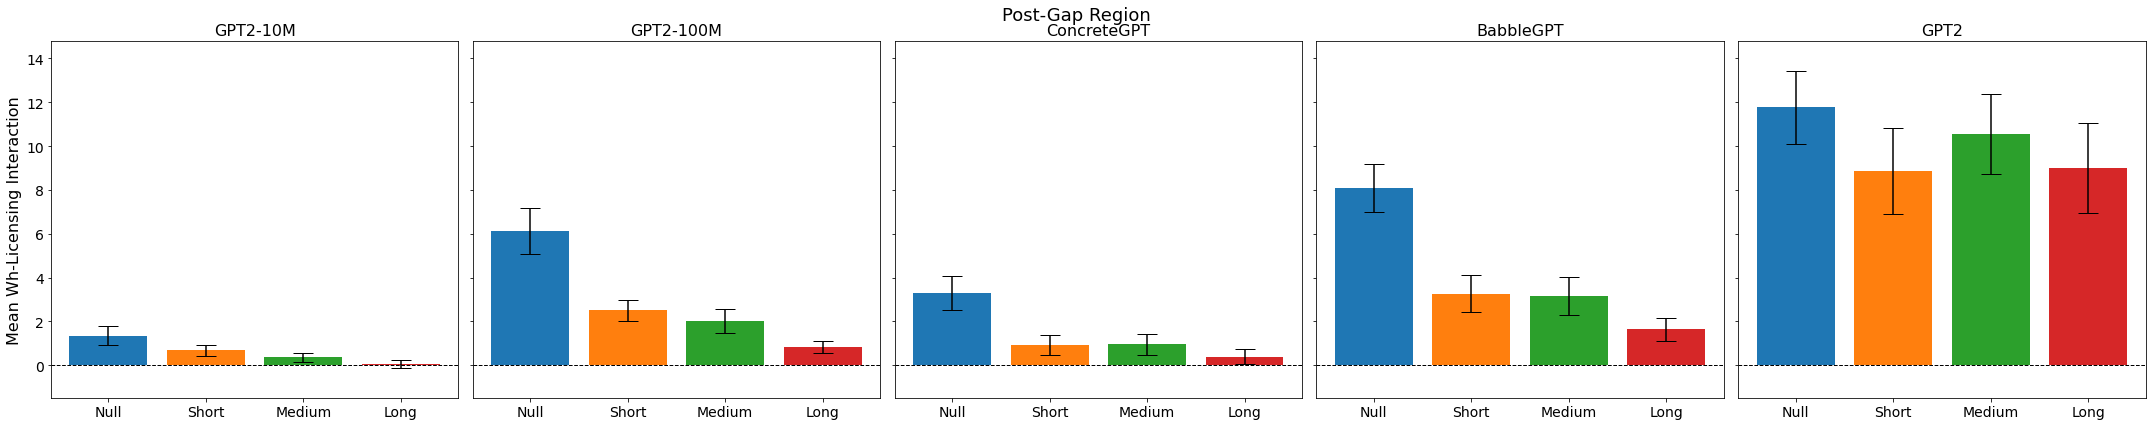

In [14]:
df_list_gpt2_10m = [null_gpt2_10m, short_gpt2_10m, medium_gpt2_10m, long_gpt2_10m]
df_list_gpt2_100m = [null_gpt2_100m, short_gpt2_100m, medium_gpt2_100m, long_gpt2_100m]
df_list_babylm_10m = [null_babylm_10m, short_babylm_10m, medium_babylm_10m, long_babylm_10m]
df_list_babylm_100m = [null_babylm_100m, short_babylm_100m, medium_babylm_100m, long_babylm_100m]
df_list_gpt2 = [null_gpt2, short_gpt2, medium_gpt2, long_gpt2]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m, df_list_babylm_10m, df_list_babylm_100m, df_list_gpt2]
subtitles = ['GPT2-10M', 'GPT2-100M', 'ConcreteGPT', 'BabbleGPT', 'GPT2']
labels = ['Null', 'Short', 'Medium', 'Long']
title = 'Post-Gap Region'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

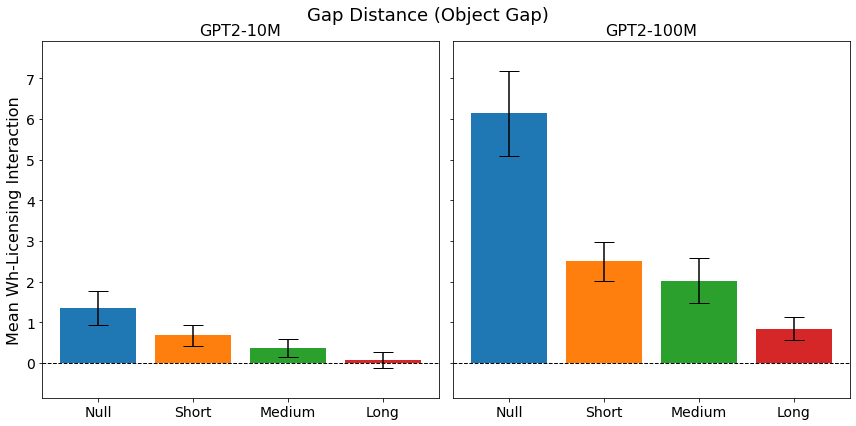

In [15]:
# if we want to look at only two models at a time
df_list_gpt2_10m = [null_gpt2_10m, short_gpt2_10m, medium_gpt2_10m, long_gpt2_10m]
df_list_gpt2_100m = [null_gpt2_100m, short_gpt2_100m, medium_gpt2_100m, long_gpt2_100m]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m]
subtitles = ['GPT2-10M', 'GPT2-100M']
labels = ['Null', 'Short', 'Medium', 'Long']
title = 'Gap Distance (Object Gap)'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

Gap Postion == PP/Goal

In [16]:
pp_df = sentence_df.copy()
pp_df['region_surprisal_gpt2_10m'] = pp_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_10m', ['temp_mod'], 'goal'), axis = 1)
pp_df['region_surprisal_gpt2_100m'] = pp_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_100m', ['temp_mod'], 'goal'), axis = 1)
pp_df['region_surprisal_babylm_10m'] = pp_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_10m', ['temp_mod'], 'goal'), axis = 1)
pp_df['region_surprisal_babylm_100m'] = pp_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_100m', ['temp_mod'], 'goal'), axis = 1)
pp_df['region_surprisal_gpt2'] = pp_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2', ['temp_mod'], 'goal'), axis = 1)

# filter for PP gap
ppgap_df = pp_df[pp_df['gap_position'] == 'IO']

In [17]:
null_df = ppgap_df[(ppgap_df['gap_distance'] == 'null')]
short_df = ppgap_df[(ppgap_df['gap_distance'] == 'short')]
medium_df = ppgap_df[(ppgap_df['gap_distance'] == 'medium')]
long_df = ppgap_df[(ppgap_df['gap_distance'] == 'long')]
null_gpt2_10m = compute_wh_licensing_interaction(null_df, 'region_surprisal_gpt2_10m')
short_gpt2_10m = compute_wh_licensing_interaction(short_df, 'region_surprisal_gpt2_10m')
medium_gpt2_10m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_gpt2_10m')
long_gpt2_10m = compute_wh_licensing_interaction(long_df, 'region_surprisal_gpt2_10m')
null_gpt2_100m = compute_wh_licensing_interaction(null_df, 'region_surprisal_gpt2_100m')
short_gpt2_100m = compute_wh_licensing_interaction(short_df, 'region_surprisal_gpt2_100m')
medium_gpt2_100m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_gpt2_100m')
long_gpt2_100m = compute_wh_licensing_interaction(long_df, 'region_surprisal_gpt2_100m')
null_babylm_10m = compute_wh_licensing_interaction(null_df, 'region_surprisal_babylm_10m')
short_babylm_10m = compute_wh_licensing_interaction(short_df, 'region_surprisal_babylm_10m')
medium_babylm_10m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_babylm_10m')
long_babylm_10m = compute_wh_licensing_interaction(long_df, 'region_surprisal_babylm_10m')
null_babylm_100m = compute_wh_licensing_interaction(null_df, 'region_surprisal_babylm_100m')
short_babylm_100m = compute_wh_licensing_interaction(short_df, 'region_surprisal_babylm_100m')
medium_babylm_100m = compute_wh_licensing_interaction(medium_df, 'region_surprisal_babylm_100m')
long_babylm_100m = compute_wh_licensing_interaction(long_df, 'region_surprisal_babylm_100m')
null_gpt2 = compute_wh_licensing_interaction(null_df, 'region_surprisal_gpt2')
short_gpt2 = compute_wh_licensing_interaction(short_df, 'region_surprisal_gpt2')
medium_gpt2 = compute_wh_licensing_interaction(medium_df, 'region_surprisal_gpt2')
long_gpt2 = compute_wh_licensing_interaction(long_df, 'region_surprisal_gpt2')

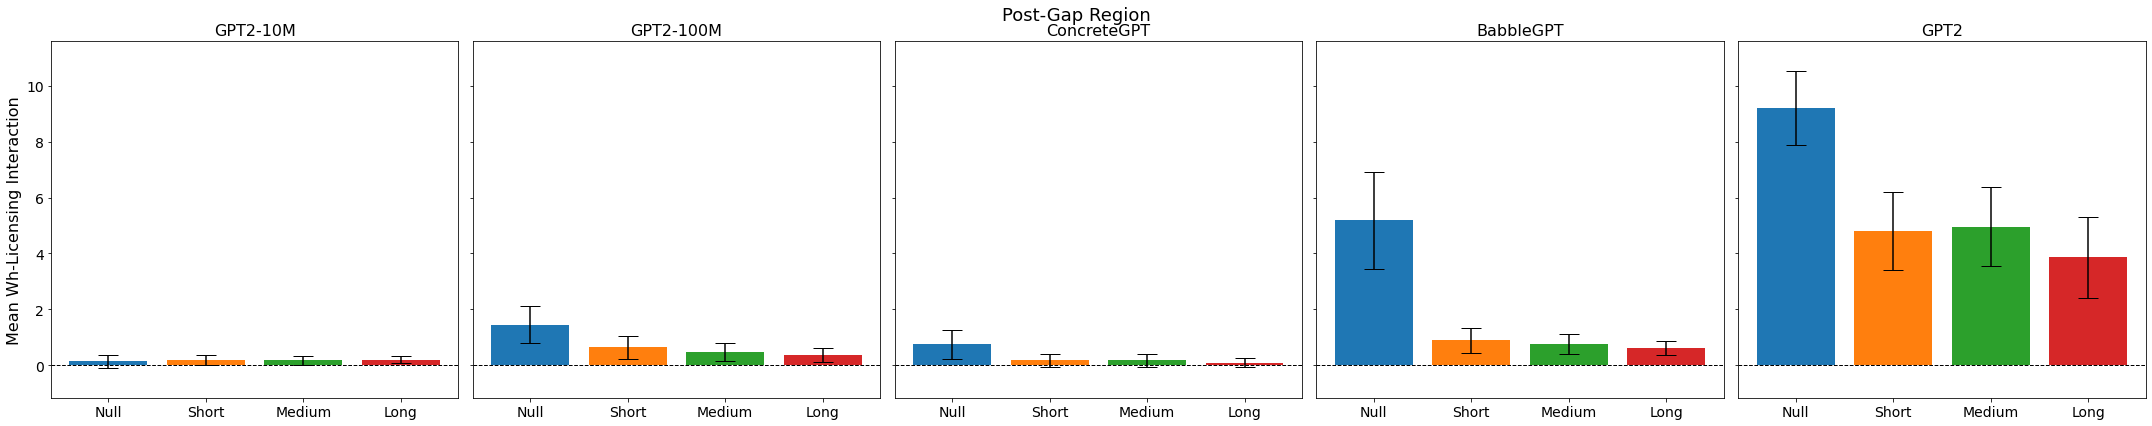

In [18]:
df_list_gpt2_10m = [null_gpt2_10m, short_gpt2_10m, medium_gpt2_10m, long_gpt2_10m]
df_list_gpt2_100m = [null_gpt2_100m, short_gpt2_100m, medium_gpt2_100m, long_gpt2_100m]
df_list_babylm_10m = [null_babylm_10m, short_babylm_10m, medium_babylm_10m, long_babylm_10m]
df_list_babylm_100m = [null_babylm_100m, short_babylm_100m, medium_babylm_100m, long_babylm_100m]
df_list_gpt2 = [null_gpt2, short_gpt2, medium_gpt2, long_gpt2]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m, df_list_babylm_10m, df_list_babylm_100m, df_list_gpt2]
subtitles = ['GPT2-10M', 'GPT2-100M', 'ConcreteGPT', 'BabbleGPT', 'GPT2']
labels = ['Null', 'Short', 'Medium', 'Long']
title = 'Post-Gap Region'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

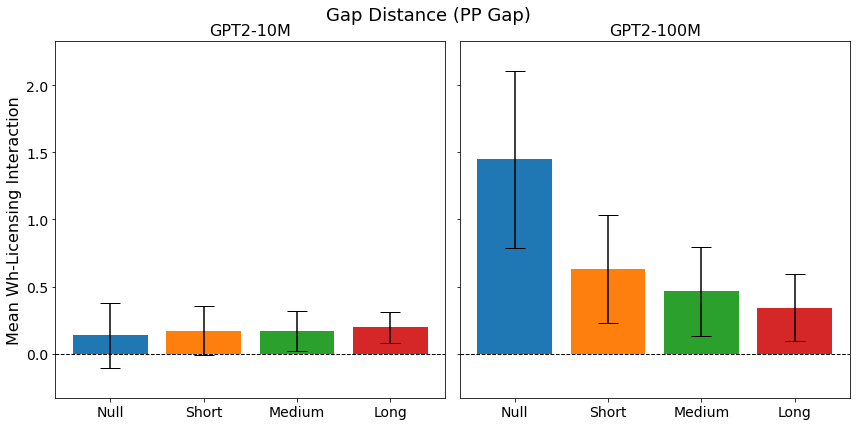

In [19]:
# if we want to look at only two models at a time
df_list_gpt2_10m = [null_gpt2_10m, short_gpt2_10m, medium_gpt2_10m, long_gpt2_10m]
df_list_gpt2_100m = [null_gpt2_100m, short_gpt2_100m, medium_gpt2_100m, long_gpt2_100m]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m]
subtitles = ['GPT2-10M', 'GPT2-100M']
labels = ['Null', 'Short', 'Medium', 'Long']
title = 'Gap Distance (PP Gap)'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

Embedded Clause

In [20]:
embed = ['subj', 'modifier', 'verb', 'object', 'prep', 'goal', 'temp_mod', 'end']
sentence_df['embed_surprisal_gpt2_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_10m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_gpt2_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_100m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_babylm_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_10m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_babylm_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_100m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_gpt2'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2', embed, normalize = True), axis = 1)

Embedded Clause - Object Gap Position

In [21]:
# filter for object gap
embed_objectgap_df = sentence_df[sentence_df['gap_position'] == 'DO']

In [22]:
null_df = embed_objectgap_df[(embed_objectgap_df['gap_distance'] == 'null')]
short_df = embed_objectgap_df[(embed_objectgap_df['gap_distance'] == 'short')]
medium_df = embed_objectgap_df[(embed_objectgap_df['gap_distance'] == 'medium')]
long_df = embed_objectgap_df[(embed_objectgap_df['gap_distance'] == 'long')]
null_gpt2_10m = compute_wh_licensing_interaction(null_df, 'embed_surprisal_gpt2_10m')
short_gpt2_10m = compute_wh_licensing_interaction(short_df, 'embed_surprisal_gpt2_10m')
medium_gpt2_10m = compute_wh_licensing_interaction(medium_df, 'embed_surprisal_gpt2_10m')
long_gpt2_10m = compute_wh_licensing_interaction(long_df, 'embed_surprisal_gpt2_10m')
null_gpt2_100m = compute_wh_licensing_interaction(null_df, 'embed_surprisal_gpt2_100m')
short_gpt2_100m = compute_wh_licensing_interaction(short_df, 'embed_surprisal_gpt2_100m')
medium_gpt2_100m = compute_wh_licensing_interaction(medium_df, 'embed_surprisal_gpt2_100m')
long_gpt2_100m = compute_wh_licensing_interaction(long_df, 'embed_surprisal_gpt2_100m')
null_babylm_10m = compute_wh_licensing_interaction(null_df, 'embed_surprisal_babylm_10m')
short_babylm_10m = compute_wh_licensing_interaction(short_df, 'embed_surprisal_babylm_10m')
medium_babylm_10m = compute_wh_licensing_interaction(medium_df, 'embed_surprisal_babylm_10m')
long_babylm_10m = compute_wh_licensing_interaction(long_df, 'embed_surprisal_babylm_10m')
null_babylm_100m = compute_wh_licensing_interaction(null_df, 'embed_surprisal_babylm_100m')
short_babylm_100m = compute_wh_licensing_interaction(short_df, 'embed_surprisal_babylm_100m')
medium_babylm_100m = compute_wh_licensing_interaction(medium_df, 'embed_surprisal_babylm_100m')
long_babylm_100m = compute_wh_licensing_interaction(long_df, 'embed_surprisal_babylm_100m')
null_gpt2 = compute_wh_licensing_interaction(null_df, 'embed_surprisal_gpt2')
short_gpt2 = compute_wh_licensing_interaction(short_df, 'embed_surprisal_gpt2')
medium_gpt2 = compute_wh_licensing_interaction(medium_df, 'embed_surprisal_gpt2')
long_gpt2 = compute_wh_licensing_interaction(long_df, 'embed_surprisal_gpt2')

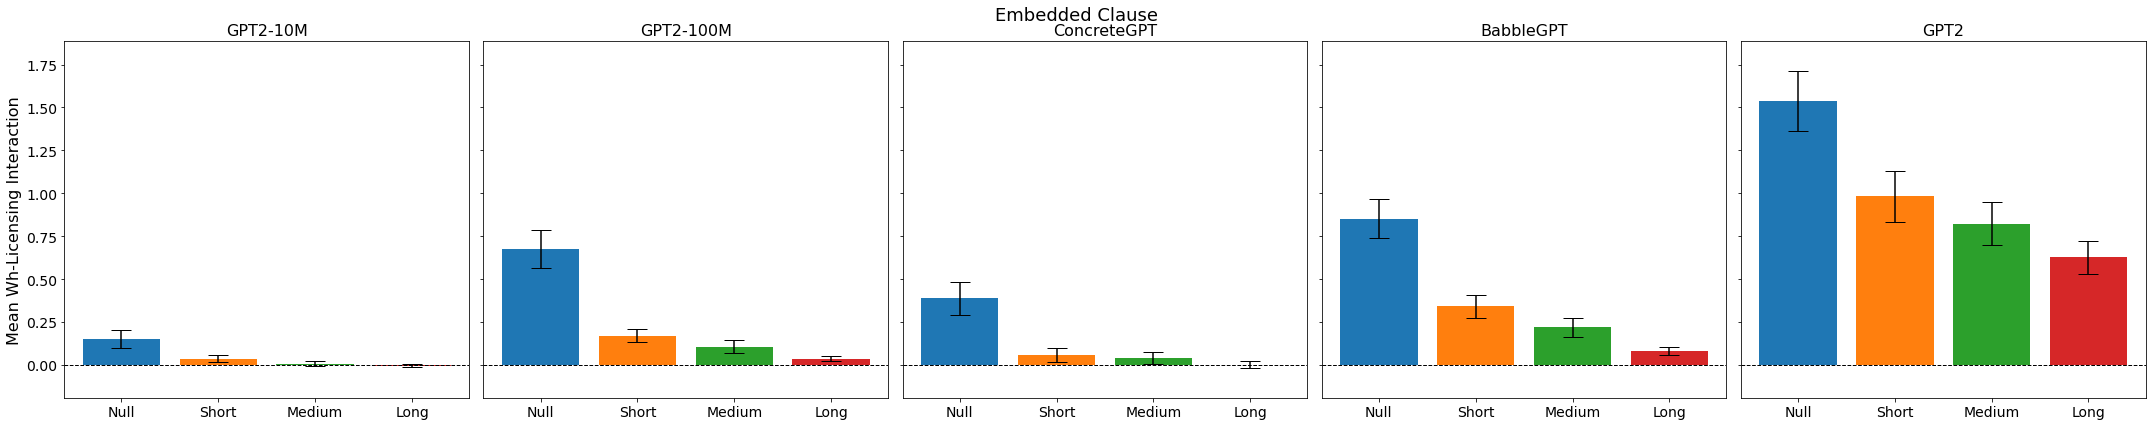

In [23]:
df_list_gpt2_10m = [null_gpt2_10m, short_gpt2_10m, medium_gpt2_10m, long_gpt2_10m]
df_list_gpt2_100m = [null_gpt2_100m, short_gpt2_100m, medium_gpt2_100m, long_gpt2_100m]
df_list_babylm_10m = [null_babylm_10m, short_babylm_10m, medium_babylm_10m, long_babylm_10m]
df_list_babylm_100m = [null_babylm_100m, short_babylm_100m, medium_babylm_100m, long_babylm_100m]
df_list_gpt2 = [null_gpt2, short_gpt2, medium_gpt2, long_gpt2]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m, df_list_babylm_10m, df_list_babylm_100m, df_list_gpt2]
subtitles = ['GPT2-10M', 'GPT2-100M', 'ConcreteGPT', 'BabbleGPT', 'GPT2']
labels = ['Null', 'Short', 'Medium', 'Long']
title = 'Embedded Clause'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

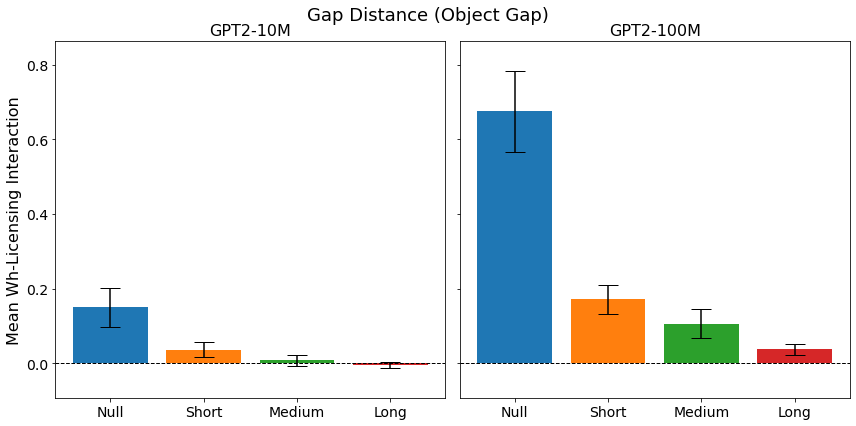

In [24]:
# if we want to look at only two models at a time
df_list_gpt2_10m = [null_gpt2_10m, short_gpt2_10m, medium_gpt2_10m, long_gpt2_10m]
df_list_gpt2_100m = [null_gpt2_100m, short_gpt2_100m, medium_gpt2_100m, long_gpt2_100m]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m]
subtitles = ['GPT2-10M', 'GPT2-100M']
labels = ['Null', 'Short', 'Medium', 'Long']
title = 'Gap Distance (Object Gap)'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

Embedded Clause - PP/Goal Gap Position

In [25]:
# filter for PP gap
embed_ppgap_df = sentence_df[sentence_df['gap_position'] == 'IO']

In [26]:
null_df = embed_ppgap_df[(embed_ppgap_df['gap_distance'] == 'null')]
short_df = embed_ppgap_df[(embed_ppgap_df['gap_distance'] == 'short')]
medium_df = embed_ppgap_df[(embed_ppgap_df['gap_distance'] == 'medium')]
long_df = embed_ppgap_df[(embed_ppgap_df['gap_distance'] == 'long')]
null_gpt2_10m = compute_wh_licensing_interaction(null_df, 'embed_surprisal_gpt2_10m')
short_gpt2_10m = compute_wh_licensing_interaction(short_df, 'embed_surprisal_gpt2_10m')
medium_gpt2_10m = compute_wh_licensing_interaction(medium_df, 'embed_surprisal_gpt2_10m')
long_gpt2_10m = compute_wh_licensing_interaction(long_df, 'embed_surprisal_gpt2_10m')
null_gpt2_100m = compute_wh_licensing_interaction(null_df, 'embed_surprisal_gpt2_100m')
short_gpt2_100m = compute_wh_licensing_interaction(short_df, 'embed_surprisal_gpt2_100m')
medium_gpt2_100m = compute_wh_licensing_interaction(medium_df, 'embed_surprisal_gpt2_100m')
long_gpt2_100m = compute_wh_licensing_interaction(long_df, 'embed_surprisal_gpt2_100m')
null_babylm_10m = compute_wh_licensing_interaction(null_df, 'embed_surprisal_babylm_10m')
short_babylm_10m = compute_wh_licensing_interaction(short_df, 'embed_surprisal_babylm_10m')
medium_babylm_10m = compute_wh_licensing_interaction(medium_df, 'embed_surprisal_babylm_10m')
long_babylm_10m = compute_wh_licensing_interaction(long_df, 'embed_surprisal_babylm_10m')
null_babylm_100m = compute_wh_licensing_interaction(null_df, 'embed_surprisal_babylm_100m')
short_babylm_100m = compute_wh_licensing_interaction(short_df, 'embed_surprisal_babylm_100m')
medium_babylm_100m = compute_wh_licensing_interaction(medium_df, 'embed_surprisal_babylm_100m')
long_babylm_100m = compute_wh_licensing_interaction(long_df, 'embed_surprisal_babylm_100m')
null_gpt2 = compute_wh_licensing_interaction(null_df, 'embed_surprisal_gpt2')
short_gpt2 = compute_wh_licensing_interaction(short_df, 'embed_surprisal_gpt2')
medium_gpt2 = compute_wh_licensing_interaction(medium_df, 'embed_surprisal_gpt2')
long_gpt2 = compute_wh_licensing_interaction(long_df, 'embed_surprisal_gpt2')

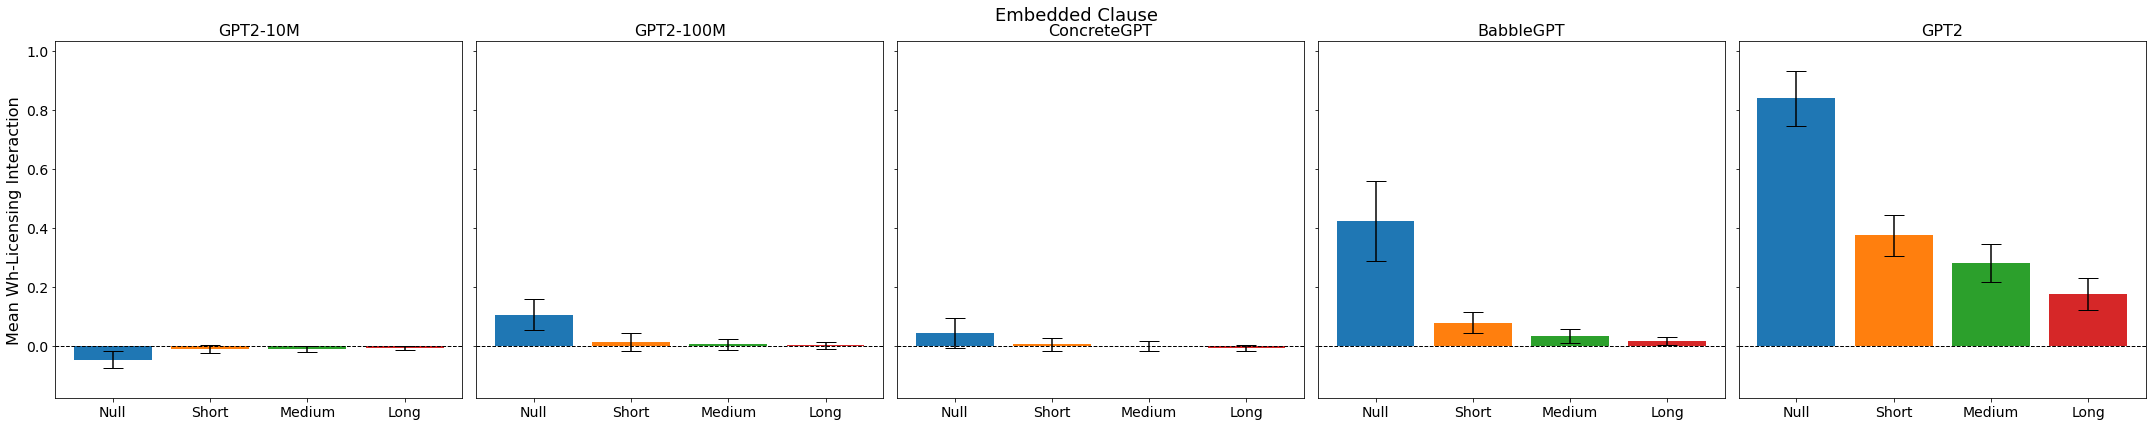

In [27]:
df_list_gpt2_10m = [null_gpt2_10m, short_gpt2_10m, medium_gpt2_10m, long_gpt2_10m]
df_list_gpt2_100m = [null_gpt2_100m, short_gpt2_100m, medium_gpt2_100m, long_gpt2_100m]
df_list_babylm_10m = [null_babylm_10m, short_babylm_10m, medium_babylm_10m, long_babylm_10m]
df_list_babylm_100m = [null_babylm_100m, short_babylm_100m, medium_babylm_100m, long_babylm_100m]
df_list_gpt2 = [null_gpt2, short_gpt2, medium_gpt2, long_gpt2]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m, df_list_babylm_10m, df_list_babylm_100m, df_list_gpt2]
subtitles = ['GPT2-10M', 'GPT2-100M', 'ConcreteGPT', 'BabbleGPT', 'GPT2']
labels = ['Null', 'Short', 'Medium', 'Long']
title = 'Embedded Clause'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

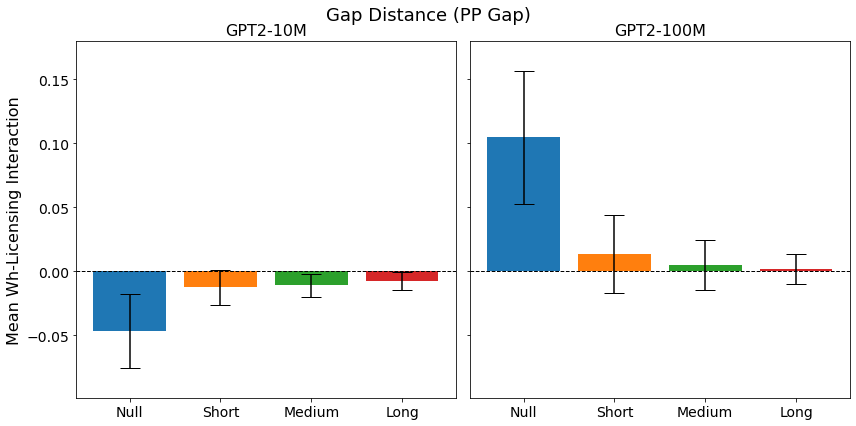

In [28]:
# if we want to look at only two models at a time
df_list_gpt2_10m = [null_gpt2_10m, short_gpt2_10m, medium_gpt2_10m, long_gpt2_10m]
df_list_gpt2_100m = [null_gpt2_100m, short_gpt2_100m, medium_gpt2_100m, long_gpt2_100m]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m]
subtitles = ['GPT2-10M', 'GPT2-100M']
labels = ['Null', 'Short', 'Medium', 'Long']
title = 'Gap Distance (PP Gap)'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

#### Double Gaps

In [29]:
from scipy.stats import sem

def plot_surprisals(df_list, column_list, subtitles, labels, title):
    '''
    Plots multiple sets of mean surprisals in separate subplots for each model.

    Args:
        df_list: List of DataFrames, each containing columns recording results from different subtypes for each model.
        column_list: List of model names or columns in each DataFrame representing different models' surprisal values.
        subtitles: List of titles for each model subplot (same length as column_list).
        labels: List of labels corresponding to each DataFrame (subtypes).
        title: Title for the entire figure.
    '''
    
    # check if the number of column_list matches the number of subtitles
    if len(column_list) != len(subtitles):
        raise ValueError("column_list and subtitles must have the same length.")
    
    means = []
    errors = []
    all_labels = []

    # colors for each subplot (will cycle if more than 10 subplots)
    colors = plt.cm.tab10.colors  # distinct colors for each set of DataFrames

    # iterate over each model (from column_list) to compute means and errors
    for column in column_list:
        means_set, errors_set = [], []
        
        for df in df_list:
            mean_effect = df[column].mean()
            stderr = sem(df[column])
            means_set.append(mean_effect)
            errors_set.append(1.96 * stderr)  # 95% CI

        means.append(means_set)
        errors.append(errors_set)
        all_labels.append(labels[:len(df_list)])  # add the appropriate labels for each group

    # calculate common y-limits based on all the plots to align the zero line
    min_y = min([m - e for means_set, errors_set in zip(means, errors) for m, e in zip(means_set, errors_set)])
    max_y = max([m + e for means_set, errors_set in zip(means, errors) for m, e in zip(means_set, errors_set)])

    # dynamically determine the grid size for subplots
    n_plots = len(column_list)  # number of models
    n_cols = len(column_list)  # number of columns in the subplot grid
    n_rows = int(np.ceil(n_plots / n_cols))  # calculate rows based on the number of plots

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))  # create dynamic grid of subplots
    axes = axes.flatten()  # flatten the axes array for easy iteration
    
    # iterate through each subplot, setting up data and appearance
    for i, ax in enumerate(axes[:n_plots]):
        subplot_colors = colors[:len(means[i])]
        ax.bar(np.arange(len(means[i])), means[i], yerr = errors[i], capsize = 10, color = subplot_colors)
        ax.set_xticks(np.arange(len(means[i])))
        ax.set_xticklabels(all_labels[i], fontsize = 14)
        #ax.set_ylabel('Mean Surprisal (Bits)')
        ax.set_title(subtitles[i], fontsize = 16)
        #ax.set_ylim(min_y - 1, max_y + 1)  # align y-axis limits
        ax.set_ylim(min_y - 0.5, max_y + 0.5)  # align y-axis limits
        ax.axhline(0, color = 'black', linewidth = 1, linestyle = '--')  # line at y=0
        #ax.tick_params(axis = 'y', labelleft = True)
        
        # only set the y-label for the first plot in each row
        if i % n_cols == 0:
            ax.set_ylabel('Mean Surprisal (Bits)', fontsize = 16)

        # remove y-axis labels for non-first plots in a row
        if i % n_cols != 0:
            ax.set_ylabel('')

        # ensure ticks appear on the left y-axis for the first plot in each row
        if i % n_cols == 0:
            ax.tick_params(axis = 'y', labelsize = 14, labelleft = True)
        else:
            ax.tick_params(axis = 'y', labelleft = False)

    # adjust layout to prevent overlap
    fig.suptitle(title, fontsize = 18)
    plt.tight_layout()
    plt.subplots_adjust(top = 0.9)  # adjust the position of the overall title
    plt.show()

In [30]:
sentence_df = pd.read_csv('test_sentences/Double Gaps.csv')

In [31]:
sentence_df[['modifier', 'end']] = sentence_df['modifier'].apply(split_ends)
sentence_df = encode_wh_licensor(sentence_df)
sentence_df['gap_numeric'] = sentence_df['gap'].replace(0, -1)
syntactic_parts = ['prefix', 'licensor', 'subj', 'verb', 'object', 'modifier']
sentence_df['sentence'] = sentence_df.apply(lambda x: merge_sentence(x, syntactic_parts), axis = 1)
sentence_df['gap_count'] = sentence_df['subject_gap'] + sentence_df['object_gap']
sentence_df['illicit_gaps'] = sentence_df['gap_count'] - sentence_df['filler']
sentence_df['surprisals_gpt2_10m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_gpt2_10m, x))
sentence_df['surprisals_gpt2_100m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_gpt2_100m, x))
sentence_df['surprisals_babylm_10m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_babylm_10m, x))
sentence_df['surprisals_babylm_100m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_babylm_100m, x))
sentence_df['surprisals_gpt2'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_gpt2, x))

Post-Gap Region - Modifier

In [32]:
sentence_df['region_surprisal_gpt2_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_10m', ['modifier'], 'object'), axis = 1)
sentence_df['region_surprisal_gpt2_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_100m', ['modifier'], 'object'), axis = 1)
sentence_df['region_surprisal_babylm_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_10m', ['modifier'], 'object'), axis = 1)
sentence_df['region_surprisal_babylm_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_100m', ['modifier'], 'object'), axis = 1)
sentence_df['region_surprisal_gpt2'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2', ['modifier'], 'object'), axis = 1)

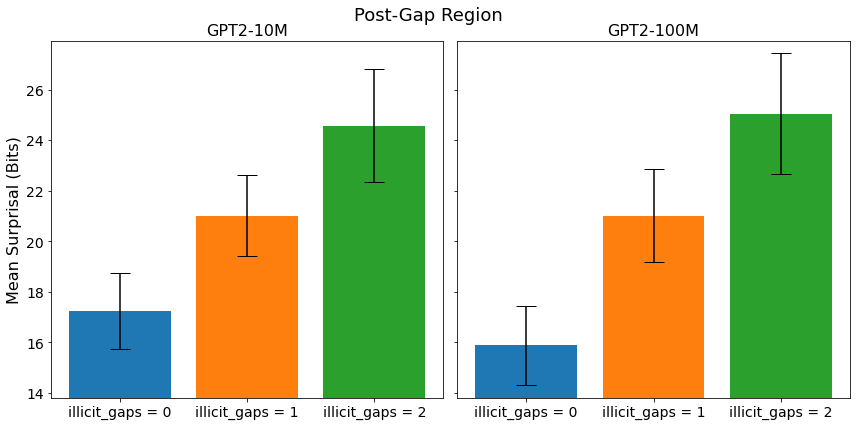

In [33]:
gap_0 = sentence_df[sentence_df['illicit_gaps'] == 0]
gap_1 = sentence_df[sentence_df['illicit_gaps'] == 1]
gap_2 = sentence_df[sentence_df['illicit_gaps'] == 2]

df_list = [gap_0, gap_1, gap_2]  
column_list = ['region_surprisal_gpt2_10m', 'region_surprisal_gpt2_100m']  
subtitles = ['GPT2-10M', 'GPT2-100M']  
labels = ['illicit_gaps = 0', 'illicit_gaps = 1', 'illicit_gaps = 2']  
title = 'Post-Gap Region'

plot_surprisals(df_list, column_list, subtitles, labels, title)

Embedded Clause

In [34]:
embed = ['subj', 'object', 'verb', 'modifier', 'end']
sentence_df['embed_surprisal_gpt2_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_10m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_gpt2_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_100m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_babylm_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_10m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_babylm_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_100m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_gpt2'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2', embed, normalize = True), axis = 1)

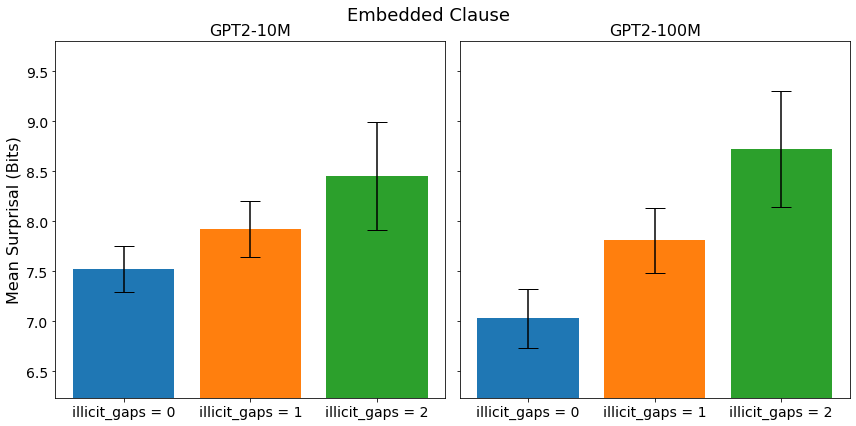

In [35]:
gap_0 = sentence_df[sentence_df['illicit_gaps'] == 0]
gap_1 = sentence_df[sentence_df['illicit_gaps'] == 1]
gap_2 = sentence_df[sentence_df['illicit_gaps'] == 2]

df_list = [gap_0, gap_1, gap_2]  
column_list = ['embed_surprisal_gpt2_10m', 'embed_surprisal_gpt2_100m']  
subtitles = ['GPT2-10M', 'GPT2-100M']  
labels = ['illicit_gaps = 0', 'illicit_gaps = 1', 'illicit_gaps = 2']  
title = 'Embedded Clause'

plot_surprisals(df_list, column_list, subtitles, labels, title)

#### Wh-Islands

In [36]:
sentence_df = pd.read_csv('test_sentences/Wh-Islands.csv')
sentence_df['comp_type'] = sentence_df['comp_type'].fillna('null')

In [37]:
sentence_df[['cont', 'end']] = sentence_df['cont'].apply(split_ends)
sentence_df = encode_wh_licensor(sentence_df)
sentence_df['gap_numeric'] = sentence_df['gap'].replace(0, -1)
syntactic_parts = ['prefix', 'filler_word', 'subj1', 'verb1', 'comp', 'subj2', 'embed_verb', 'obj', 'cont']
sentence_df['sentence'] = sentence_df.apply(lambda x: merge_sentence (x, syntactic_parts), axis = 1)
sentence_df['comp_type'] = pd.Categorical(sentence_df['comp_type'], categories = ['null', 'that', 'whether'], ordered = True)
sentence_df['surprisals_gpt2_10m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_gpt2_10m, x))
sentence_df['surprisals_gpt2_100m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_gpt2_100m, x))
sentence_df['surprisals_babylm_10m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_babylm_10m, x))
sentence_df['surprisals_babylm_100m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_babylm_100m, x))
sentence_df['surprisals_gpt2'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_gpt2, x))

Post Gap Region - Continuation

In [38]:
sentence_df['region_surprisal_gpt2_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_10m', ['cont'], 'obj'), axis = 1)
sentence_df['region_surprisal_gpt2_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_100m', ['cont'], 'obj'), axis = 1)
sentence_df['region_surprisal_babylm_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_10m', ['cont'], 'obj'), axis = 1)
sentence_df['region_surprisal_babylm_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_100m', ['cont'], 'obj'), axis = 1)
sentence_df['region_surprisal_gpt2'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2', ['cont'], 'obj'), axis = 1)

In [39]:
null_comp_df = sentence_df[(sentence_df['comp_type'] == 'null')]
that_comp_df = sentence_df[(sentence_df['comp_type'] == 'that')]
wh_comp_df = sentence_df[(sentence_df['comp_type'] == 'whether')]
null_comp_gpt2_10m = compute_wh_licensing_interaction(null_comp_df, 'region_surprisal_gpt2_10m')
that_comp_gpt2_10m = compute_wh_licensing_interaction(that_comp_df, 'region_surprisal_gpt2_10m')
wh_comp_gpt2_10m = compute_wh_licensing_interaction(wh_comp_df, 'region_surprisal_gpt2_10m')
null_comp_gpt2_100m = compute_wh_licensing_interaction(null_comp_df, 'region_surprisal_gpt2_100m')
that_comp_gpt2_100m = compute_wh_licensing_interaction(that_comp_df, 'region_surprisal_gpt2_100m')
wh_comp_gpt2_100m = compute_wh_licensing_interaction(wh_comp_df, 'region_surprisal_gpt2_100m')
null_comp_babylm_10m = compute_wh_licensing_interaction(null_comp_df, 'region_surprisal_babylm_10m')
that_comp_babylm_10m = compute_wh_licensing_interaction(that_comp_df, 'region_surprisal_babylm_10m')
wh_comp_babylm_10m = compute_wh_licensing_interaction(wh_comp_df, 'region_surprisal_babylm_10m')
null_comp_babylm_100m = compute_wh_licensing_interaction(null_comp_df, 'region_surprisal_babylm_100m')
that_comp_babylm_100m = compute_wh_licensing_interaction(that_comp_df, 'region_surprisal_babylm_100m')
wh_comp_babylm_100m = compute_wh_licensing_interaction(wh_comp_df, 'region_surprisal_babylm_100m')
null_comp_gpt2 = compute_wh_licensing_interaction(null_comp_df, 'region_surprisal_gpt2')
that_comp_gpt2 = compute_wh_licensing_interaction(that_comp_df, 'region_surprisal_gpt2')
wh_comp_gpt2 = compute_wh_licensing_interaction(wh_comp_df, 'region_surprisal_gpt2')
null_comp_gpt2 = compute_wh_licensing_interaction(null_comp_df, 'region_surprisal_gpt2')
that_comp_gpt2 = compute_wh_licensing_interaction(that_comp_df, 'region_surprisal_gpt2')
wh_comp_gpt2 = compute_wh_licensing_interaction(wh_comp_df, 'region_surprisal_gpt2')

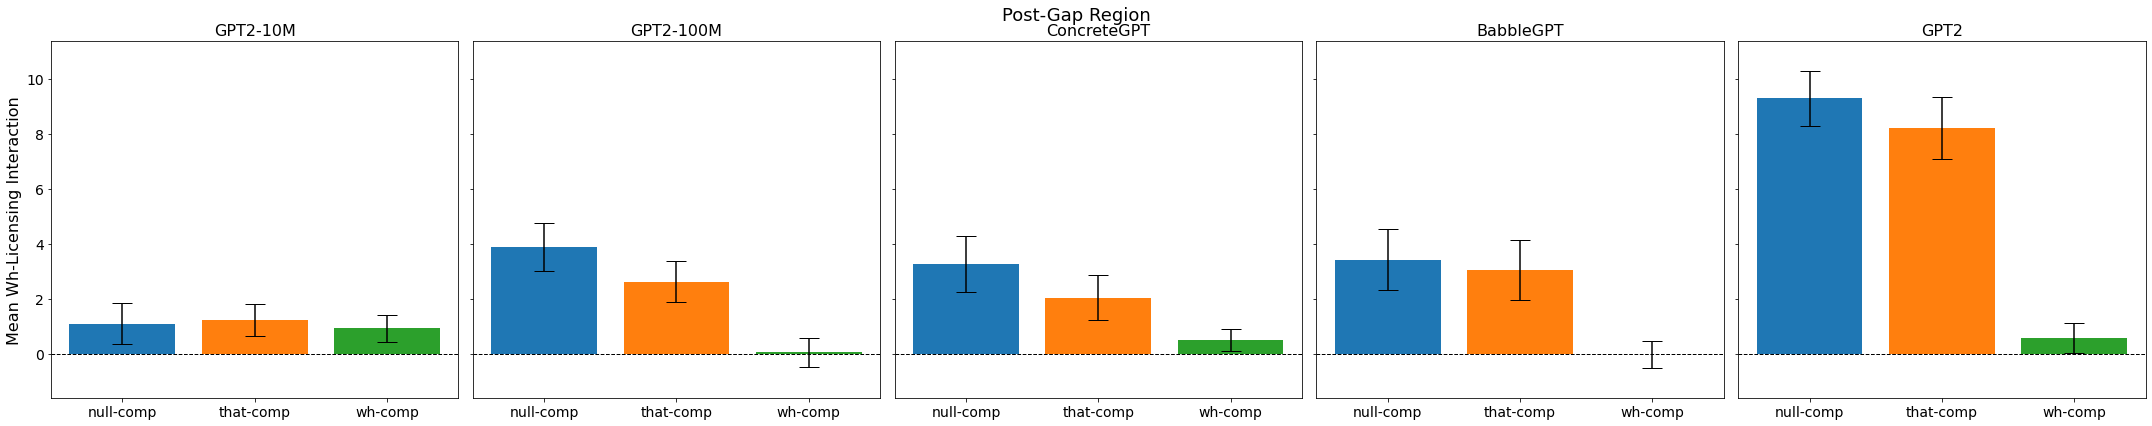

In [40]:
df_list_gpt2_10m = [null_comp_gpt2_10m, that_comp_gpt2_10m, wh_comp_gpt2_10m]
df_list_gpt2_100m = [null_comp_gpt2_100m, that_comp_gpt2_100m, wh_comp_gpt2_100m]
df_list_babylm_10m = [null_comp_babylm_10m, that_comp_babylm_10m, wh_comp_babylm_10m]
df_list_babylm_100m = [null_comp_babylm_100m, that_comp_babylm_100m, wh_comp_babylm_100m]
df_list_gpt2 = [null_comp_gpt2, that_comp_gpt2, wh_comp_gpt2]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m, df_list_babylm_10m, df_list_babylm_100m, df_list_gpt2]
subtitles = ['GPT2-10M', 'GPT2-100M', 'ConcreteGPT', 'BabbleGPT', 'GPT2']
labels = ['null-comp', 'that-comp', 'wh-comp']
title = 'Post-Gap Region'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

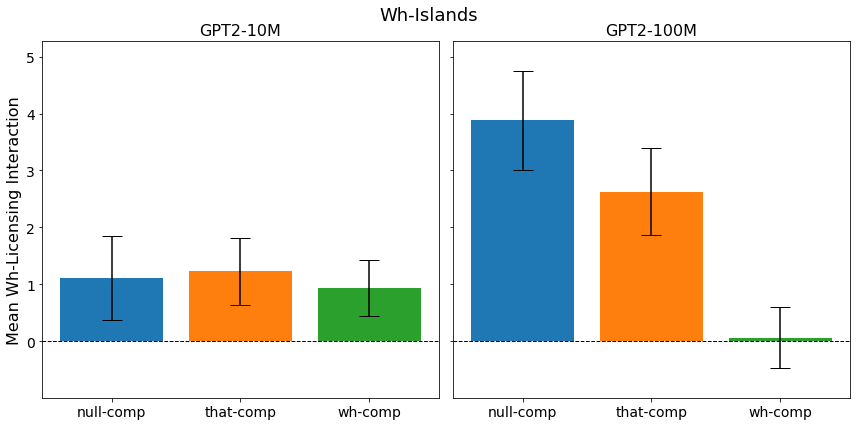

In [41]:
# if we want to look at only two models at a time
df_list_gpt2_10m = [null_comp_gpt2_10m, that_comp_gpt2_10m, wh_comp_gpt2_10m]
df_list_gpt2_100m = [null_comp_gpt2_100m, that_comp_gpt2_100m, wh_comp_gpt2_100m]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m]
subtitles = ['GPT2-10M', 'GPT2-100M']
labels = ['null-comp', 'that-comp', 'wh-comp']
title = 'Wh-Islands'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

Embedded Clause

In [42]:
embed = ['subj1', 'verb1', 'comp', 'subj2', 'embed_verb', 'obj', 'cont', 'end']
sentence_df['embed_surprisal_gpt2_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_10m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_gpt2_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_100m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_babylm_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_10m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_babylm_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_100m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_gpt2'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2', embed, normalize = True), axis = 1)

In [43]:
null_comp_df = sentence_df[(sentence_df['comp_type'] == 'null')]
that_comp_df = sentence_df[(sentence_df['comp_type'] == 'that')]
wh_comp_df = sentence_df[(sentence_df['comp_type'] == 'whether')]
null_comp_gpt2_10m = compute_wh_licensing_interaction(null_comp_df, 'embed_surprisal_gpt2_10m')
that_comp_gpt2_10m = compute_wh_licensing_interaction(that_comp_df, 'embed_surprisal_gpt2_10m')
wh_comp_gpt2_10m = compute_wh_licensing_interaction(wh_comp_df, 'embed_surprisal_gpt2_10m')
null_comp_gpt2_100m = compute_wh_licensing_interaction(null_comp_df, 'embed_surprisal_gpt2_100m')
that_comp_gpt2_100m = compute_wh_licensing_interaction(that_comp_df, 'embed_surprisal_gpt2_100m')
wh_comp_gpt2_100m = compute_wh_licensing_interaction(wh_comp_df, 'embed_surprisal_gpt2_100m')
null_comp_babylm_10m = compute_wh_licensing_interaction(null_comp_df, 'embed_surprisal_babylm_10m')
that_comp_babylm_10m = compute_wh_licensing_interaction(that_comp_df, 'embed_surprisal_babylm_10m')
wh_comp_babylm_10m = compute_wh_licensing_interaction(wh_comp_df, 'embed_surprisal_babylm_10m')
null_comp_babylm_100m = compute_wh_licensing_interaction(null_comp_df, 'embed_surprisal_babylm_100m')
that_comp_babylm_100m = compute_wh_licensing_interaction(that_comp_df, 'embed_surprisal_babylm_100m')
wh_comp_babylm_100m = compute_wh_licensing_interaction(wh_comp_df, 'embed_surprisal_babylm_100m')
null_comp_gpt2 = compute_wh_licensing_interaction(null_comp_df, 'embed_surprisal_gpt2')
that_comp_gpt2 = compute_wh_licensing_interaction(that_comp_df, 'embed_surprisal_gpt2')
wh_comp_gpt2 = compute_wh_licensing_interaction(wh_comp_df, 'embed_surprisal_gpt2')
null_comp_gpt2 = compute_wh_licensing_interaction(null_comp_df, 'embed_surprisal_gpt2')
that_comp_gpt2 = compute_wh_licensing_interaction(that_comp_df, 'embed_surprisal_gpt2')
wh_comp_gpt2 = compute_wh_licensing_interaction(wh_comp_df, 'embed_surprisal_gpt2')

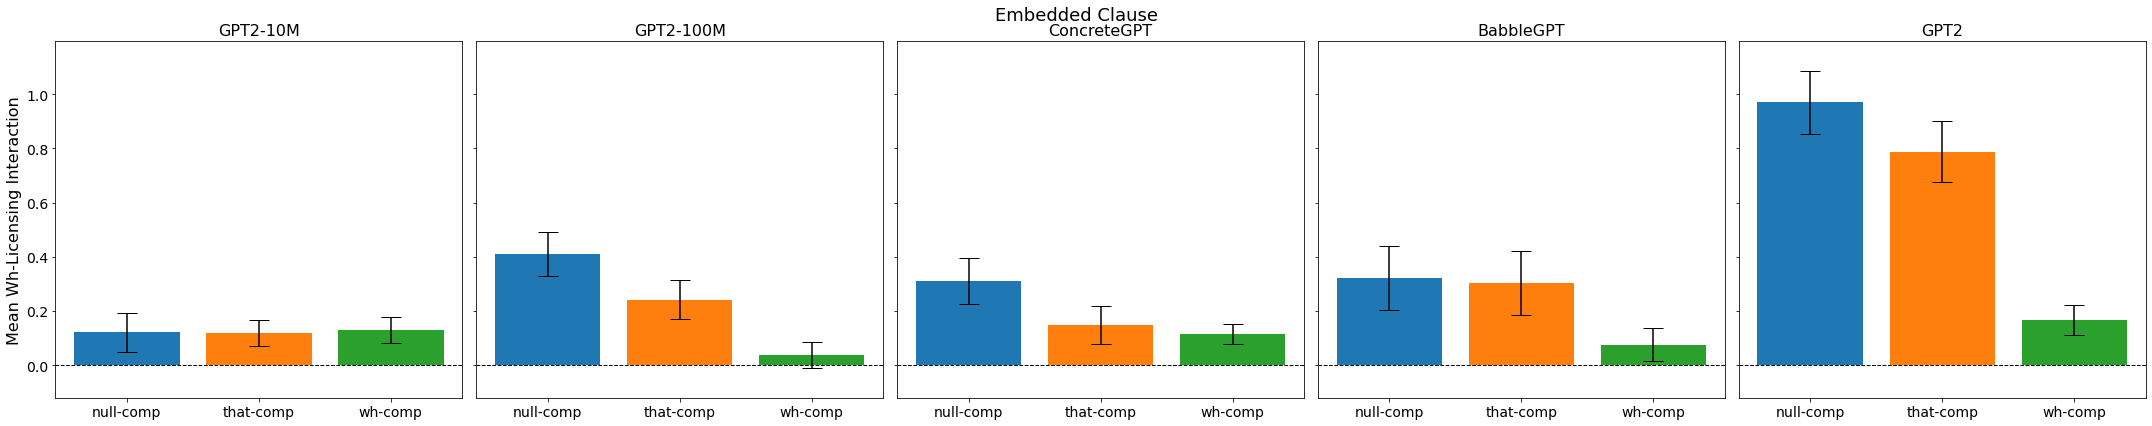

In [44]:
df_list_gpt2_10m = [null_comp_gpt2_10m, that_comp_gpt2_10m, wh_comp_gpt2_10m]
df_list_gpt2_100m = [null_comp_gpt2_100m, that_comp_gpt2_100m, wh_comp_gpt2_100m]
df_list_babylm_10m = [null_comp_babylm_10m, that_comp_babylm_10m, wh_comp_babylm_10m]
df_list_babylm_100m = [null_comp_babylm_100m, that_comp_babylm_100m, wh_comp_babylm_100m]
df_list_gpt2 = [null_comp_gpt2, that_comp_gpt2, wh_comp_gpt2]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m, df_list_babylm_10m, df_list_babylm_100m, df_list_gpt2]
subtitles = ['GPT2-10M', 'GPT2-100M', 'ConcreteGPT', 'BabbleGPT', 'GPT2']
labels = ['null-comp', 'that-comp', 'wh-comp']
title = 'Embedded Clause'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

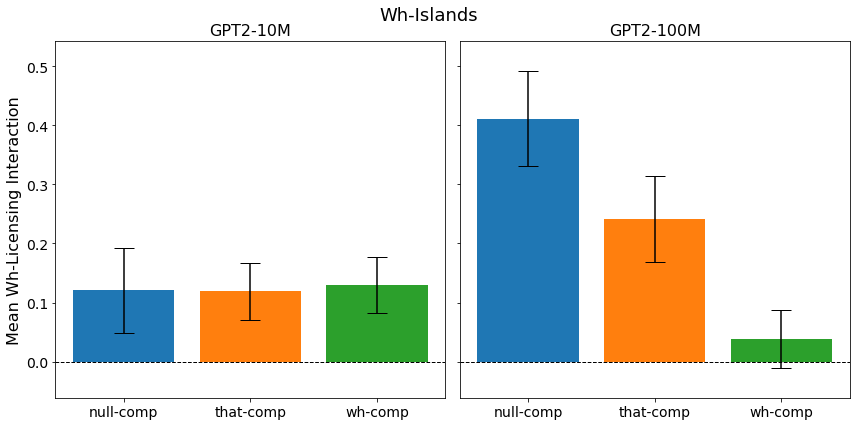

In [45]:
# if we want to look at only two models at a time
df_list_gpt2_10m = [null_comp_gpt2_10m, that_comp_gpt2_10m, wh_comp_gpt2_10m]
df_list_gpt2_100m = [null_comp_gpt2_100m, that_comp_gpt2_100m, wh_comp_gpt2_100m]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m]
subtitles = ['GPT2-10M', 'GPT2-100M']
labels = ['null-comp', 'that-comp', 'wh-comp']
title = 'Wh-Islands'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

#### Adjunct Islands 

In [46]:
sentence_df = pd.read_csv('test_sentences/Adjunct Islands.csv')
sentence_df['adjunct_type'] = sentence_df['adjunct_type'].fillna('null')

In [47]:
sentence_df[['cont', 'end']] = sentence_df['cont'].apply(split_ends)
sentence_df['adjunct_front_trigger'] = np.nan
sentence_df['adjunct_front_trigger'] = sentence_df['adjunct_trigger'].where(sentence_df['adjunct_type'] == 'front', sentence_df['adjunct_front_trigger'])
sentence_df['adjunct_trigger'] = sentence_df['adjunct_trigger'].where(sentence_df['adjunct_type'] != 'front', np.nan)
sentence_df.rename(columns = {'adjunct_trigger': 'adjunct_back_trigger'}, inplace = True)
sentence_df = sentence_df[[col for col in sentence_df.columns if col != 'end'] + ['end']]

In [48]:
sentence_df = encode_wh_licensor(sentence_df)
sentence_df['gap_numeric'] = sentence_df['gap'].replace(0, -1)
syntactic_parts = ['prefix', 'filler_word', 'adjunct_back_trigger', 'prep', 'subj', 'mod', 'verb', 'obj', 'cont', 'adjunct_front_trigger']
sentence_df['sentence'] = sentence_df.apply(lambda x: merge_sentence(x, syntactic_parts), axis = 1)
sentence_df['adjunct_type'] = pd.Categorical(sentence_df['adjunct_type'], categories = ['null', 'back', 'front'], ordered = True)
sentence_df['surprisals_gpt2_10m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_gpt2_10m, x))
sentence_df['surprisals_gpt2_100m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_gpt2_100m, x))
sentence_df['surprisals_babylm_10m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_babylm_10m, x))
sentence_df['surprisals_babylm_100m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_babylm_100m, x))
sentence_df['surprisals_gpt2'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_gpt2, x))

Post-Gap Region - Continuation

In [49]:
sentence_df['region_surprisal_gpt2_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_10m', ['cont'], 'obj'), axis = 1)
sentence_df['region_surprisal_gpt2_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_100m', ['cont'], 'obj'), axis = 1)
sentence_df['region_surprisal_babylm_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_10m', ['cont'], 'obj'), axis = 1)
sentence_df['region_surprisal_babylm_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_100m', ['cont'], 'obj'), axis = 1)
sentence_df['region_surprisal_gpt2'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2', ['cont'], 'obj'), axis = 1)

In [50]:
object_df = sentence_df[(sentence_df['adjunct_type'] == 'null')]
adjunct_back_df = sentence_df[(sentence_df['adjunct_type'] == 'back')]
adjunct_front_df = sentence_df[(sentence_df['adjunct_type'] == 'front')]
object_gpt2_10m = compute_wh_licensing_interaction(object_df, 'region_surprisal_gpt2_10m')
adjunct_back_gpt2_10m = compute_wh_licensing_interaction(adjunct_back_df, 'region_surprisal_gpt2_10m')
adjunct_front_gpt2_10m = compute_wh_licensing_interaction(adjunct_front_df, 'region_surprisal_gpt2_10m')
object_gpt2_100m = compute_wh_licensing_interaction(object_df, 'region_surprisal_gpt2_100m')
adjunct_back_gpt2_100m = compute_wh_licensing_interaction(adjunct_back_df, 'region_surprisal_gpt2_100m')
adjunct_front_gpt2_100m = compute_wh_licensing_interaction(adjunct_front_df, 'region_surprisal_gpt2_100m')
object_babylm_10m = compute_wh_licensing_interaction(object_df, 'region_surprisal_babylm_10m')
adjunct_back_babylm_10m = compute_wh_licensing_interaction(adjunct_back_df, 'region_surprisal_babylm_10m')
adjunct_front_babylm_10m = compute_wh_licensing_interaction(adjunct_front_df, 'region_surprisal_babylm_10m')
object_babylm_100m = compute_wh_licensing_interaction(object_df, 'region_surprisal_babylm_100m')
adjunct_back_babylm_100m = compute_wh_licensing_interaction(adjunct_back_df, 'region_surprisal_babylm_100m')
adjunct_front_babylm_100m = compute_wh_licensing_interaction(adjunct_front_df, 'region_surprisal_babylm_100m')
object_gpt2 = compute_wh_licensing_interaction(object_df, 'region_surprisal_gpt2')
adjunct_back_gpt2 = compute_wh_licensing_interaction(adjunct_back_df, 'region_surprisal_gpt2')
adjunct_front_gpt2 = compute_wh_licensing_interaction(adjunct_front_df, 'region_surprisal_gpt2')
object_gpt2 = compute_wh_licensing_interaction(object_df, 'region_surprisal_gpt2')
adjunct_back_gpt2 = compute_wh_licensing_interaction(adjunct_back_df, 'region_surprisal_gpt2')
adjunct_front_gpt2 = compute_wh_licensing_interaction(adjunct_front_df, 'region_surprisal_gpt2')

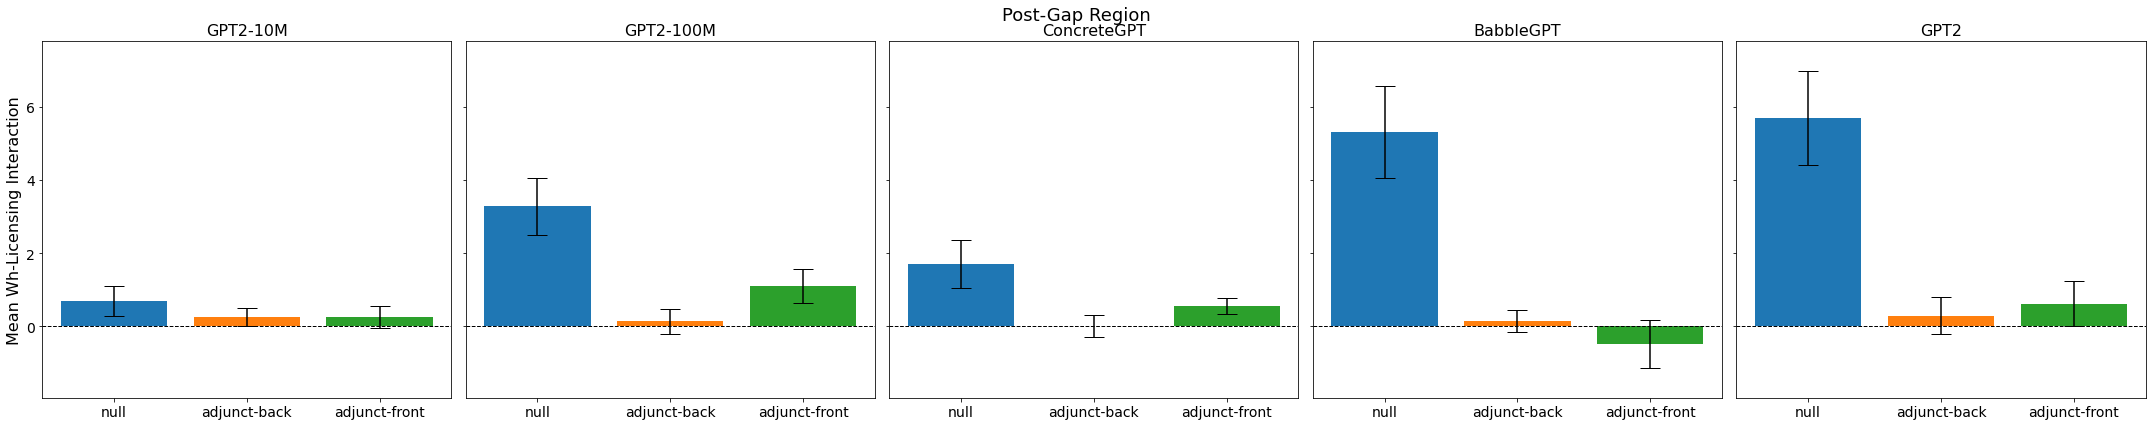

In [51]:
df_list_gpt2_10m = [object_gpt2_10m, adjunct_back_gpt2_10m, adjunct_front_gpt2_10m]
df_list_gpt2_100m = [object_gpt2_100m, adjunct_back_gpt2_100m, adjunct_front_gpt2_100m]
df_list_babylm_10m = [object_babylm_10m, adjunct_back_babylm_10m, adjunct_front_babylm_10m]
df_list_babylm_100m = [object_babylm_100m, adjunct_back_babylm_100m, adjunct_front_babylm_100m]
df_list_gpt2 = [object_gpt2, adjunct_back_gpt2, adjunct_front_gpt2]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m, df_list_babylm_10m, df_list_babylm_100m, df_list_gpt2]
subtitles = ['GPT2-10M', 'GPT2-100M', 'ConcreteGPT', 'BabbleGPT', 'GPT2']
labels =  ['null', 'adjunct-back', 'adjunct-front']
title = 'Post-Gap Region'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

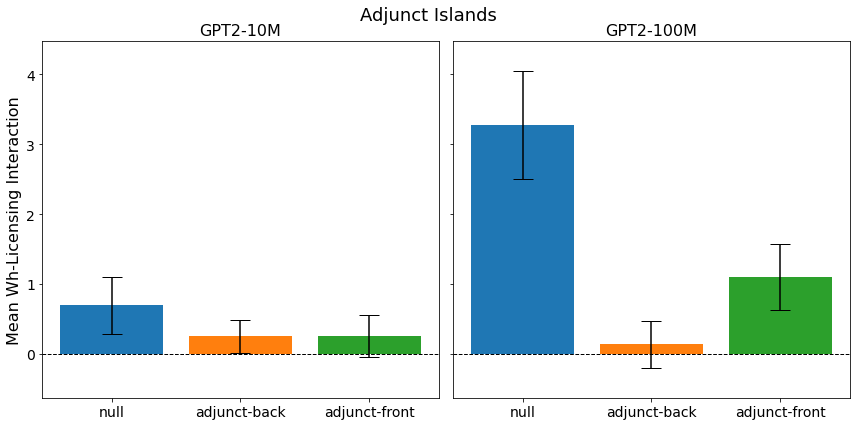

In [52]:
# if we want to look at only two models at a time
df_list_gpt2_10m = [object_gpt2_10m, adjunct_back_gpt2_10m, adjunct_front_gpt2_10m]
df_list_gpt2_100m = [object_gpt2_100m, adjunct_back_gpt2_100m, adjunct_front_gpt2_100m]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m]
subtitles = ['GPT2-10M', 'GPT2-100M']
labels = ['null', 'adjunct-back', 'adjunct-front']
title = 'Adjunct Islands'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

Embedded Clause

In [53]:
embed = ['adjunct_back_trigger', 'prep', 'subj', 'mod', 'verb', 'obj', 'cont', 'adjunct_front_trigger', 'end']
sentence_df['embed_surprisal_gpt2_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_10m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_gpt2_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2_100m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_babylm_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_10m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_babylm_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_babylm_100m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_gpt2'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_gpt2', embed, normalize = True), axis = 1)

In [54]:
object_df = sentence_df[(sentence_df['adjunct_type'] == 'null')]
adjunct_back_df = sentence_df[(sentence_df['adjunct_type'] == 'back')]
adjunct_front_df = sentence_df[(sentence_df['adjunct_type'] == 'front')]
object_gpt2_10m = compute_wh_licensing_interaction(object_df, 'embed_surprisal_gpt2_10m')
adjunct_back_gpt2_10m = compute_wh_licensing_interaction(adjunct_back_df, 'embed_surprisal_gpt2_10m')
adjunct_front_gpt2_10m = compute_wh_licensing_interaction(adjunct_front_df, 'embed_surprisal_gpt2_10m')
object_gpt2_100m = compute_wh_licensing_interaction(object_df, 'embed_surprisal_gpt2_100m')
adjunct_back_gpt2_100m = compute_wh_licensing_interaction(adjunct_back_df, 'embed_surprisal_gpt2_100m')
adjunct_front_gpt2_100m = compute_wh_licensing_interaction(adjunct_front_df, 'embed_surprisal_gpt2_100m')
object_babylm_10m = compute_wh_licensing_interaction(object_df, 'embed_surprisal_babylm_10m')
adjunct_back_babylm_10m = compute_wh_licensing_interaction(adjunct_back_df, 'embed_surprisal_babylm_10m')
adjunct_front_babylm_10m = compute_wh_licensing_interaction(adjunct_front_df, 'embed_surprisal_babylm_10m')
object_babylm_100m = compute_wh_licensing_interaction(object_df, 'embed_surprisal_babylm_100m')
adjunct_back_babylm_100m = compute_wh_licensing_interaction(adjunct_back_df, 'embed_surprisal_babylm_100m')
adjunct_front_babylm_100m = compute_wh_licensing_interaction(adjunct_front_df, 'embed_surprisal_babylm_100m')
object_gpt2 = compute_wh_licensing_interaction(object_df, 'embed_surprisal_gpt2')
adjunct_back_gpt2 = compute_wh_licensing_interaction(adjunct_back_df, 'embed_surprisal_gpt2')
adjunct_front_gpt2 = compute_wh_licensing_interaction(adjunct_front_df, 'embed_surprisal_gpt2')
object_gpt2 = compute_wh_licensing_interaction(object_df, 'embed_surprisal_gpt2')
adjunct_back_gpt2 = compute_wh_licensing_interaction(adjunct_back_df, 'embed_surprisal_gpt2')
adjunct_front_gpt2 = compute_wh_licensing_interaction(adjunct_front_df, 'embed_surprisal_gpt2')

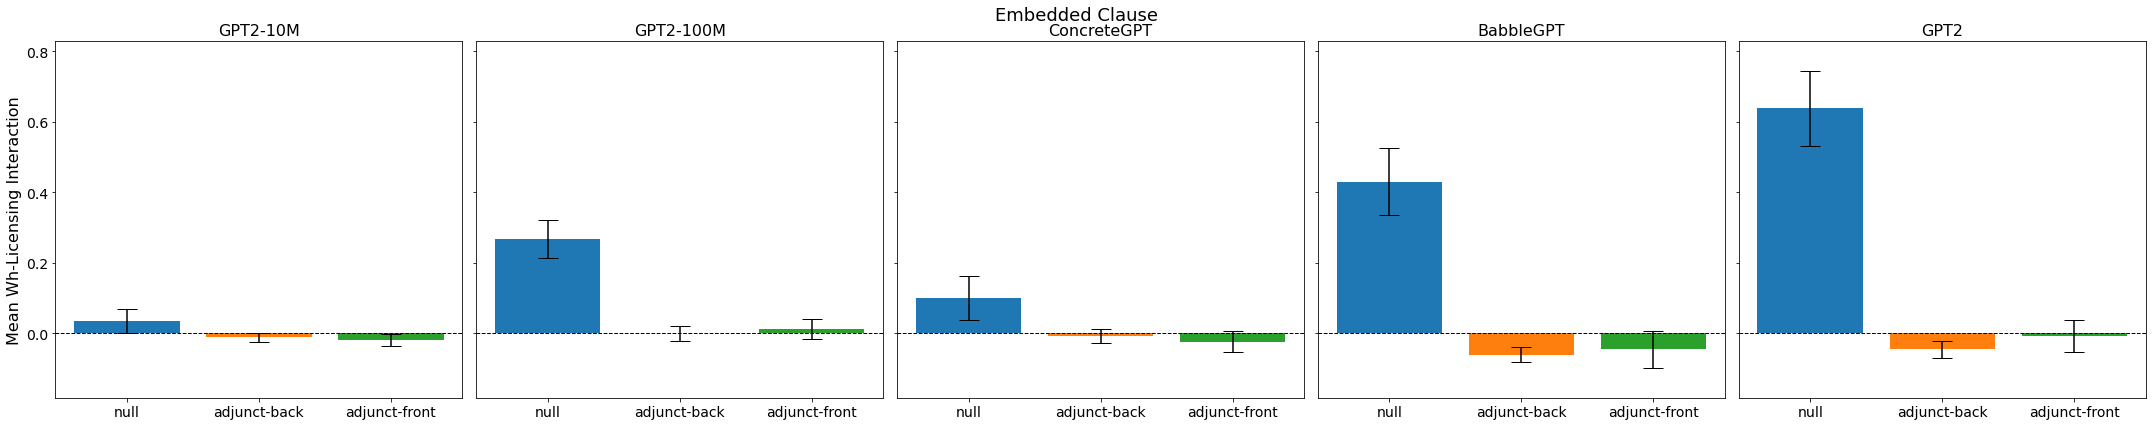

In [55]:
df_list_gpt2_10m = [object_gpt2_10m, adjunct_back_gpt2_10m, adjunct_front_gpt2_10m]
df_list_gpt2_100m = [object_gpt2_100m, adjunct_back_gpt2_100m, adjunct_front_gpt2_100m]
df_list_babylm_10m = [object_babylm_10m, adjunct_back_babylm_10m, adjunct_front_babylm_10m]
df_list_babylm_100m = [object_babylm_100m, adjunct_back_babylm_100m, adjunct_front_babylm_100m]
df_list_gpt2 = [object_gpt2, adjunct_back_gpt2, adjunct_front_gpt2]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m, df_list_babylm_10m, df_list_babylm_100m, df_list_gpt2]
subtitles = ['GPT2-10M', 'GPT2-100M', 'ConcreteGPT', 'BabbleGPT', 'GPT2']
labels =  ['null', 'adjunct-back', 'adjunct-front']
title = 'Embedded Clause'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

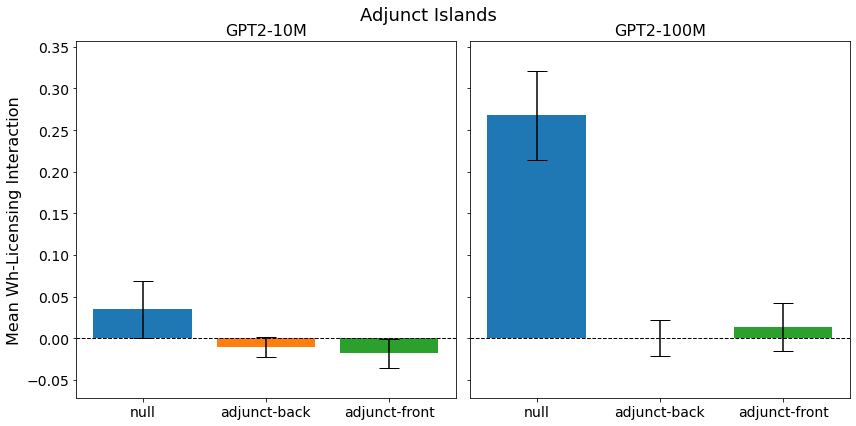

In [56]:
# if we want to look at only two models at a time
df_list_gpt2_10m = [object_gpt2_10m, adjunct_back_gpt2_10m, adjunct_front_gpt2_10m]
df_list_gpt2_100m = [object_gpt2_100m, adjunct_back_gpt2_100m, adjunct_front_gpt2_100m]
df_lists = [df_list_gpt2_10m, df_list_gpt2_100m]
subtitles = ['GPT2-10M', 'GPT2-100M']
labels = ['null', 'adjunct-back', 'adjunct-front']
title = 'Adjunct Islands'
plot_wh_licensing_interaction(df_lists, subtitles, labels, title)

#### Complex NP Islands

In [ ]:
sentence_df = pd.read_csv('test_sentences/Complex NP Islands.csv')

In [ ]:
sentence_df = encode_wh_licensor(sentence_df)
sentence_df['gap_numeric'] = sentence_df['gap'].replace(0, -1)
sentence_df['sentence'] = sentence_df.apply(merge_sentence, axis = 1)
sentence_df['surprisals_10m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_10m, x))
sentence_df['surprisals_100m'] = sentence_df['sentence'].apply(lambda x: calculate_surprisal(lm_scorer_100m, x))

Subject Condition

In [ ]:
subject_df = sentence_df.copy()

In [ ]:
subject_df['region_surprisal_10m'] = subject_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['subj_setup']), axis = 1)
subject_df['region_surprisal_100m'] = subject_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['subj_setup']), axis = 1)

In [ ]:
# filter for subject condition
subject_df = subject_df[subject_df['subj_obj'] == 'subject']

Object Condition

In [ ]:
object_df = sentence_df.copy()

In [ ]:
object_df['region_surprisal_10m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', ['end']), axis = 1)
object_df['region_surprisal_100m'] = object_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', ['end']), axis = 1)

In [ ]:
# filter for object gap
object_df = object_df[object_df['subj_obj'] == 'object']

Embedded Clause

In [ ]:
embed = ['subj', 'that_rc', 'what_rc', 'rc_np', 'prep', 'prep_np', 'subj_setup', 'obj_setup', 'end']
sentence_df['embed_surprisal_10m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_10m', embed, normalize = True), axis = 1)
sentence_df['embed_surprisal_100m'] = sentence_df.apply(lambda x: sum_region_surprisal(x, 'surprisals_100m', embed, normalize = True), axis = 1)

Embedded Clause - Subject Condition

In [ ]:
# filter for subject condition
subject_df = sentence_df[sentence_df['subj_obj'] == 'subject']

Embedded Clause - Object Condition

In [ ]:
# filter for object gap
object_df = sentence_df[sentence_df['subj_obj'] == 'object']